In [1]:
# --- Installing Libraries ---
!pip install ydata-profiling
!pip install highlight-text
!pip install prophet

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # plot the Petrol (USD)line chart
import seaborn as sns # plot the distribution
import ydata_profiling
import os
from prophet import Prophet
from ydata_profiling import ProfileReport
from PIL import Image
from IPython.display import FileLink
from highlight_text import fig_text
from prophet.plot import plot_plotly, plot_components_plotly
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/petrol-price-forecasting/sample_submission.csv
/kaggle/input/petrol-price-forecasting/train_data.csv
/kaggle/input/petrol-price-forecasting/test_data.csv


# **Dataset Loading**

In [3]:
train_data = pd.read_csv('/kaggle/input/petrol-price-forecasting/train_data.csv')
test_data  = pd.read_csv('/kaggle/input/petrol-price-forecasting/test_data.csv')

# **Exploratory Data Analysis(EDA)**

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 813 entries, 0 to 812
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          813 non-null    object 
 1   Petrol (USD)  811 non-null    float64
dtypes: float64(1), object(1)
memory usage: 12.8+ KB


In [5]:
train_data.describe()

,Petrol (USD)
count,811.000000
mean,110.330481
std,19.241182
min,74.210000
25%,94.525000
50%,112.420000
75%,128.560000
max,189.510000


In [6]:
test_data.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Date,Prediction
0,1/1/2019,NaN
1,1/2/2019,NaN
2,1/3/2019,NaN
3,1/4/2019,NaN
4,1/5/2019,NaN


# **Data Processing**

In [7]:
# Remove rows with ANY missing values in train_df
train_data.dropna(inplace=True)

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 811 entries, 0 to 812
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          811 non-null    object 
 1   Petrol (USD)  811 non-null    float64
dtypes: float64(1), object(1)
memory usage: 19.0+ KB


In [9]:
train_data.rename(columns={"Petrol (USD)": "Price"}, inplace = True)
train_data.head()

,Date,Price
0,6/9/2003,74.59
1,6/16/2003,74.47
2,6/23/2003,74.42
3,6/30/2003,74.35
4,7/7/2003,74.28


# **Data Visualization**

In [10]:
# Define the color variable  
color_line = '#1f77b4'  # Adjust the color as per your preference.  

# Generate the profile report
profile = ProfileReport(train_data,
                        title='Date And Price Trained Dataset Report',
                        minimal=True,
                        progress_bar=False,
                        samples=None,
                        correlations=None,
                        interactions=None,
                        explorative=True,
                        notebook={'iframe': {'height': '1000px', 'width': '95%'}},
                        html={'style': {'primary_color': color_line}},
                        missing_diagrams={'heatmap': False, 'dendrogram': False})

# Show the report  
profile.to_notebook_iframe() 

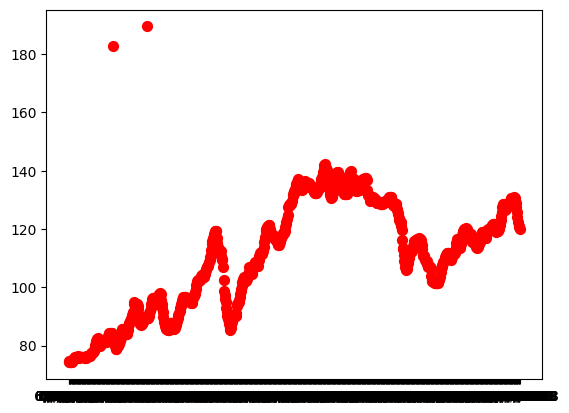

In [11]:
plt.scatter(train_data.Date, train_data.Price,color='red',label='Prices', s=50)

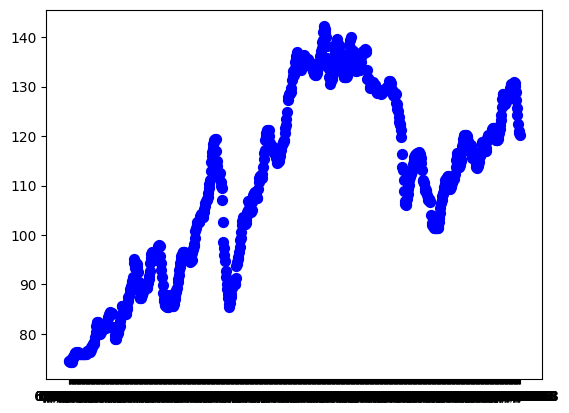

In [12]:
trained=train_data[train_data.Price<160]
plt.scatter(trained.Date, trained.Price,color='blue',label='Prices', s=50)

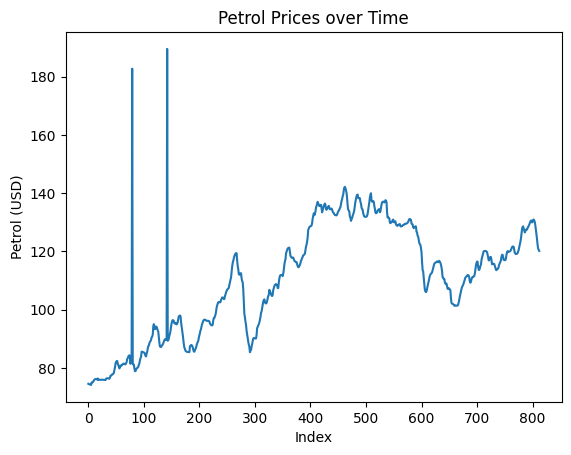

In [13]:
# plot the Petrol(USD) line chart
plt.plot(train_data['Price'])
plt.xlabel('Index')
plt.ylabel('Petrol (USD)')
plt.title('Petrol Prices over Time')
plt.show()

<ipython-input-14-5ce09b624282>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_data['Price'])
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


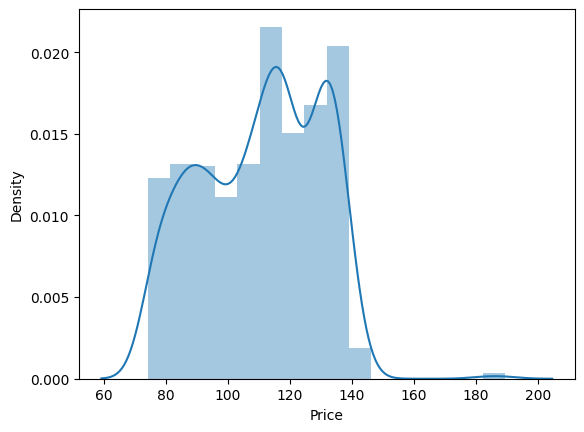

In [14]:
# plot the distribution
sns.distplot(train_data['Price'])
plt.show()

# **Data Modelling**

In [15]:
# Prophet requires that your DataFrame has two columns: 'ds' and 'y'
# 'ds' should be a column of date or datetime values
# 'y' should be a column of numeric values representing your target variable

train_data = train_data.rename(columns={'Date': 'ds', 'Price': 'y'})
train_data['ds'] = pd.to_datetime(train_data['ds'])

In [16]:
# Create Prophet model
model = Prophet(interval_width=0.80, daily_seasonality=True)

# Fit the model to the data
model.fit(train_data)

15:18:02 - cmdstanpy - INFO - Chain [1] start processing
15:18:03 - cmdstanpy - INFO - Chain [1] done processing


In [17]:
# dataframe for predictions
future =pd.DataFrame(test_data['Date'])
future=future.rename(columns={'Date':'ds'})
future['ds'] = pd.to_datetime(future['ds'])
future

,ds
0,2019-01-01
1,2019-01-02
2,2019-01-03
3,2019-01-04
4,2019-01-05
5,2019-01-06
6,2019-01-07
7,2019-01-08
8,2019-01-09
9,2019-01-10


**ds** and **yhat** are column names used in the output of the Prophet library in Python for time series forecasting.

**ds** stands for "datestamp" and it represents the time axis in the dataset. It is a column containing the timestamps of the time series data, usually in a pandas datetime format.

**yhat** represents the predicted values of the time series at each timestamp. It is a column containing the predicted values of the time series data, usually in the same format as the original data.

In [18]:
# Make predictions
forecast = model.predict(future)
predict=forecast[['ds', 'yhat']]
predict

,ds,yhat
0,2019-01-01,121.292346
1,2019-01-02,125.523565
2,2019-01-03,123.172700
3,2019-01-04,123.174432
4,2019-01-05,123.203012
5,2019-01-06,123.256468
6,2019-01-07,123.172425
7,2019-01-08,121.465284
8,2019-01-09,125.862616
9,2019-01-10,123.661062


The resulting plot shows the original time series data as black points, the predicted values as a blue line, and the shaded region as a blue area around the line. The shaded region represents the uncertainty of the predictions and is calculated based on the uncertainty of the model parameters.

Overall, the prediction plot is a useful tool for visualizing the forecasted values and understanding the uncertainty of the predictions. It can help you to identify trends, patterns, and anomalies in the data, and evaluate the performance of the model.

In [19]:
# Plot the predictions
plot_plotly(model,forecast)

In [20]:
# plot the model componets
plot_components_plotly(model, forecast)

/usr/local/lib/python3.10/dist-packages/plotly/io/_json.py:560: UserWarning:

Discarding nonzero nanoseconds in conversion.



# **Exported Output**

In [21]:
# assuming `predict` is the dataframe with predicted values
submission = predict.rename(columns={'ds':'Date','yhat':'Prediction'})

# save the dataframe as a CSV file
submission.to_csv('submission.csv', index=False)

# download the CSV file
FileLink('submission.csv')

/kaggle/working/submission.csv